In [1]:
import pdb
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import pylab as plt
from astropy.wcs import WCS
from astropy.io import fits
import readcol
from utils import shift_twod
from utils import dist_idl
from utils import loggen
from utils import gauss_kern
from lmfit import Parameters, minimize, fit_report
from simstack.simstack import stack_libraries_in_redshift_slices
from skymaps import Skymaps
from skymaps import Field_catalogs

%matplotlib inline  

In [2]:
popcolor=['blue','red','green','orange','black','grey','chocolate','darkviolet','pink','magenta','dodgerblue','lavender','blue','red','green','orange','black','grey','chocolate','darkviolet','pink','magenta','dodgerblue','lavender']

In [3]:
z_lo = np.array([0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5])
z_hi = np.array([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0])
z_nodes = np.array([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0])
z_mid = (z_nodes[:-1] + z_nodes[1:])/2
nz = len(z_nodes) - 1

m_lo = np.array([8.5, 9.5,10.0,10.5,11.0])
m_hi = np.array([9.5,10.0,10.5,11.0,13.0])
m_nodes = np.array([8.5, 9.5,10.0,10.5,11.0,13.0])
m_mid = (m_nodes[:-1] + m_nodes[1:])/2
nm = len(m_nodes) - 1

In [4]:
wv0 = np.array([1,1,1,1,1,1])
#wv0 = np.array([1,0,1,0,1,1])
indstack = np.where(wv0 == 1)
mapname=['_green'
         ,'_red'
         ,'_PSW'
         ,'_PMW'
         ,'_PLW'
         ,'_aztec'
        ]
library_keys =['pacs_green'
               ,'pacs_red'
               ,'spire_PSW'
               ,'spire_PMW'
               ,'spire_PLW'
               ,'aztec'
              ]
wavelength=[100,160,250,350,500,1100]
nwv = np.sum(wv0)#len(mapname)
fwhm =[7.4, 11.3,18.1, 25.2, 36.6,18.]
efwhm=[6.7, 11.2,17.6, 23.9, 35.2,18.] # want to the measured effective FWHM later
color_correction=[23.58,23.82,1.018,0.9914,0.95615,1.0]

dir_spire_maps = '/data/maps_cats_models/maps/herschel/hermes/cosmos/'
dir_pacs_maps = '/data/maps_cats_models/maps/herschel/pacs/pep_cosmos_DR1/maps/'
dir_aztec_maps = '/data/maps_cats_models/maps/aztec/cosmos/forPeter/'
maps = [dir_spire_maps+'cosmos-cropped-uvista_5.0_arcsec_pixels_green_flux.fits' 
        #dir_pacs_maps+'pep_COSMOS_green_Map.DR1.fits'
        ,dir_spire_maps+'cosmos-cropped-uvista_5.0_arcsec_pixels_red_flux.fits' 
        #,dir_pacs_maps+'pep_COSMOS_red_Map.DR1.fits'
        ,dir_spire_maps+'cosmos-cropped-uvista-hipe12_itermap_10_iterations_5.0_arcsec_pixels_PSW_flux.fits'
        ,dir_spire_maps+'cosmos-cropped-uvista-hipe12_itermap_10_iterations_5.0_arcsec_pixels_PMW_flux.fits'
        ,dir_spire_maps+'cosmos-cropped-uvista-hipe12_itermap_10_iterations_5.0_arcsec_pixels_PLW_flux.fits'
        #,dir_aztec_maps+'cosmos_jcmt_kscott20100925_map.fits'
        ,dir_spire_maps+'cosmos-cropped-uvista_5.0_arcsec_pixels_aztec_flux.fits'
       ]
noises = [dir_spire_maps+'cosmos-cropped-uvista_5.0_arcsec_pixels_green_noise.fits' 
          #dir_pacs_maps+'pep_COSMOS_green_Map.DR1.err.fits'
          ,dir_spire_maps+'cosmos-cropped-uvista_5.0_arcsec_pixels_red_noise.fits' 
          #,dir_pacs_maps+'pep_COSMOS_red_Map.DR1.err.fits' 
          ,dir_spire_maps+'cosmos-cropped-uvista-hipe12_itermap_10_iterations_5.0_arcsec_pixels_PSW_noise.fits'
          ,dir_spire_maps+'cosmos-cropped-uvista-hipe12_itermap_10_iterations_5.0_arcsec_pixels_PMW_noise.fits'
          ,dir_spire_maps+'cosmos-cropped-uvista-hipe12_itermap_10_iterations_5.0_arcsec_pixels_PLW_noise.fits'
          #,dir_aztec_maps+'cosmos_jcmt_kscott20100925_weight.fits'
          ,dir_spire_maps+'cosmos-cropped-uvista_5.0_arcsec_pixels_aztec_noise.fits'
         ]#weight??
beams = ['/data/maps_cats_models/maps/herschel/pacs/pep_cosmos_DR1/PSF_observed_used/pep_COSMOS_green_Psf.DR1.fits'
         ,'/data/maps_cats_models/maps/herschel/pacs/pep_cosmos_DR1/PSF_observed_used/pep_COSMOS_red_Psf.DR1.fits'
         ,'/data/maps_cats_models/maps/beams/SPIRE/model/psw-model-beam_5_arcsec_pixels.fits'
         ,'/data/maps_cats_models/maps/beams/SPIRE/model/pmw-model-beam_5_arcsec_pixels.fits'
         ,'/data/maps_cats_models/maps/beams/SPIRE/model/plw-model-beam_5_arcsec_pixels.fits'
         ,'/data/maps_cats_models/maps/beams/aztec/aztec-beam_5_arcsec_pixels.fits'
        ]
sedstackbeams = [beams[0],beams[1],beams[2],beams[3],beams[4],beams[5]]

In [5]:
sky_library_gaussians={}
sky_library_psfs={}

for t in indstack[0]:
    #sky_library[library_keys[t]] = Skymaps(maps[t],noises[t],beams[t],color_correction=color_correction[t])
    sky_library_gaussians[library_keys[t]] = Skymaps(maps[t],noises[t],efwhm[t],color_correction=color_correction[t])
    sky_library_psfs[library_keys[t]] = Skymaps(maps[t],noises[t],sedstackbeams[t],color_correction=color_correction[t])
    sky_library_gaussians[library_keys[t]].add_wavelength(wavelength[t])
    sky_library_gaussians[library_keys[t]].add_fwhm(efwhm[t])    
    sky_library_psfs[library_keys[t]].add_wavelength(wavelength[t])
    sky_library_psfs[library_keys[t]].add_fwhm(efwhm[t])

In [6]:
path_catalog = '/data/maps_cats_models/catalogs/UVISTA/'
file_catalog = 'UVISTA_final_v4.1_zCOSMOS_zEAZY_RFcolors_IDs_mass_AGN_SFRs_parentids.csv'

In [7]:
tbl = pd.read_table(path_catalog+file_catalog,sep=',')

In [8]:
uVista = Field_catalogs(tbl)

In [9]:
# This function creates a column 'sfg', where sf == 1 and qt == 0
uVista.separate_sf_qt()

In [10]:
# This will seperate into sf/qt, redshift, and mass bins according to the z & m inputs
# Note, N z_nodes returns N-1 bins, etc.
uVista.get_sf_qt_mass_redshift_bins(z_nodes,m_nodes)

In [11]:
uVista.get_parent_child_redshift_bins(z_nodes)

In [12]:
# This function requires 'parents' and 'parent_id' columns in table
uVista.get_parent_child_bins()

stacking spire_PSW
stacking aztec
stacking pacs_red
stacking spire_PMW
stacking spire_PLW
stacking pacs_green


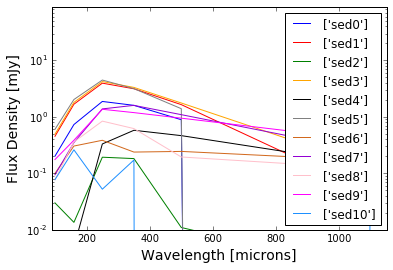

stacking spire_PSW
stacking aztec
stacking pacs_red
stacking spire_PMW
stacking spire_PLW
stacking pacs_green


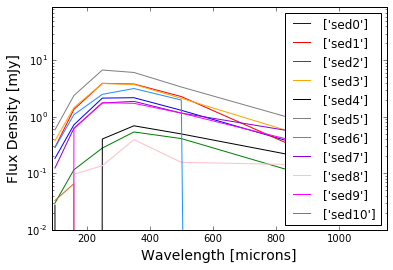

stacking spire_PSW
stacking aztec
stacking pacs_red
stacking spire_PMW
stacking spire_PLW
stacking pacs_green


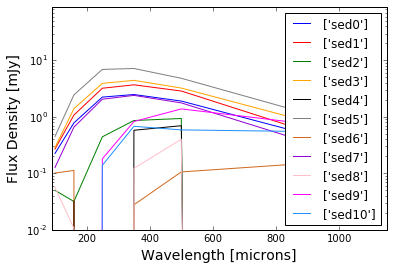

stacking spire_PSW
stacking aztec
stacking pacs_red
stacking spire_PMW
stacking spire_PLW
stacking pacs_green


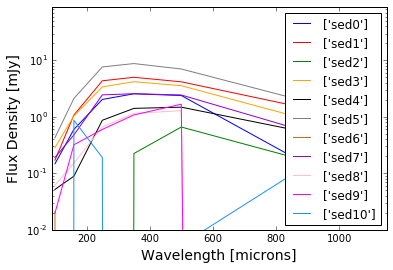

stacking spire_PSW
stacking aztec
stacking pacs_red
stacking spire_PMW
stacking spire_PLW
stacking pacs_green


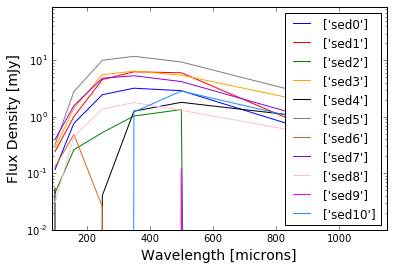

stacking spire_PSW
stacking aztec
stacking pacs_red
stacking spire_PMW
stacking spire_PLW
stacking pacs_green


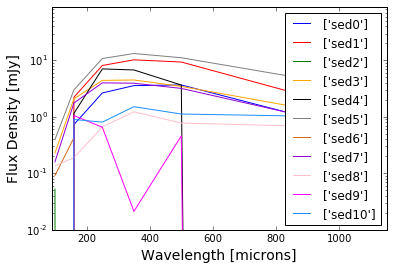

stacking spire_PSW
stacking aztec
stacking pacs_red
stacking spire_PMW
stacking spire_PLW
stacking pacs_green


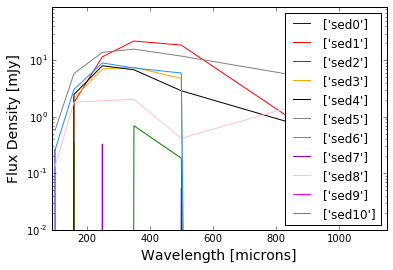

In [16]:
#Stack by redshift and SED type
npop=len(uVista.table.parent.unique())
all_stacked_fluxes_psfs = np.zeros([nwv,nz,npop])
all_luminosity_temp_psfs= np.zeros([nz,npop,2])
all_stacked_fluxes_gaussians = np.zeros([nwv,nz,npop])
all_luminosity_temp_gaussians= np.zeros([nz,npop,2])

for iz in range(nz):
    zn = z_nodes[iz:iz+2]
    uVista.get_parent_child_redshift_bins(zn)
    radec_z_sed = uVista.subset_positions(uVista.id_z_sed)
    stacked_fluxes_psfs =  None
    n_sources_max = None 
    
    #pdb.set_trace()
    stacked_fluxes_gaussians = stack_libraries_in_redshift_slices(
        sky_library_gaussians,
        radec_z_sed)
    #stacked_fluxes_psfs = stack_libraries_in_redshift_slices(
    #    sky_library_psfs,
    #    radec_z_sed)
    
    #pdb.set_trace()
    args = radec_z_sed.keys()
    for iwv in range(nwv):
        stacked_fluxes_wv = stacked_fluxes_gaussians[str(wavelength[indstack[0][iwv]])]
        for k in range(npop):
            arg = 'z_'+str(zn[0])+'-'+str(zn[1])+'__sed'+str(k)
            all_stacked_fluxes_gaussians[iwv,iz,k] = stacked_fluxes_wv[arg.replace('.','p').replace('-','_')].value
                

    #pdb.set_trace()
    #PLOT
    plt.ylim([-1e-1,3e0])
    plt.ylim([1e-2,9e1])
    plt.xlim([90,510])
    plt.xlim([90,1150])
    plt.yscale('log')
    plt.ylabel('Flux Density [mJy]',fontsize=14)
    plt.xlabel('Wavelength [microns]',fontsize=14)
    for k in range(npop):
        plt.plot(np.array(wavelength)[indstack],1e3*all_stacked_fluxes_gaussians[:,iz,k],color=popcolor[k],label=['sed'+str(k)])
        plt.legend()
    plt.show()

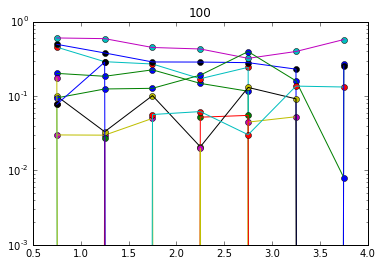

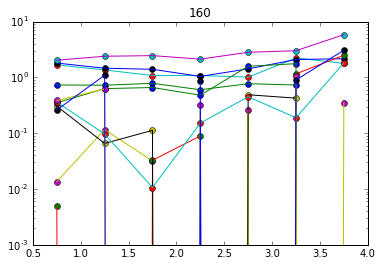

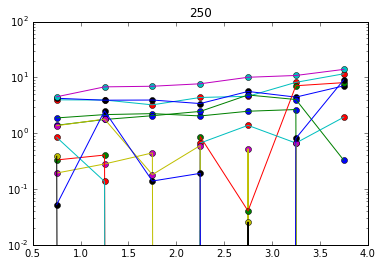

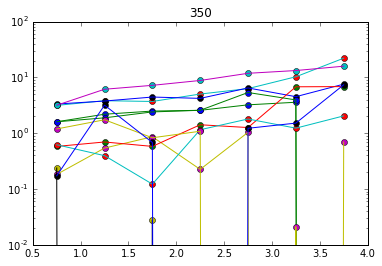

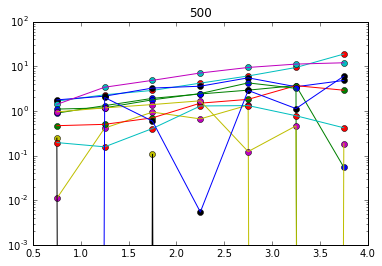

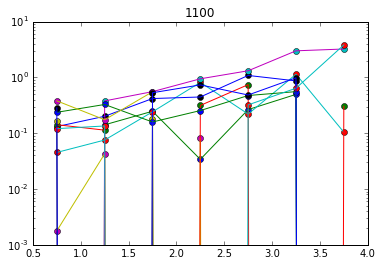

In [17]:
for iwv in range(len(wavelength)):
    plt.figure()
    for k in range(npop):
        plt.yscale('log')
        plt.title(str(wavelength[iwv]))
        plt.plot(z_mid,1e3*(all_stacked_fluxes_gaussians[iwv,:,k]),'o')
        plt.plot(z_mid,1e3*(all_stacked_fluxes_gaussians[iwv,:,k]))
    plt.show()

In [ ]:
iz=2
zn = z_nodes[iz:iz+2]
uVista.get_sf_qt_mass_redshift_bins(zn,m_nodes)
radec_m_z_p = uVista.subset_positions(uVista.id_z_ms)
radec_m_z_p.keys()

In [ ]:
#Stack by Z, M, SF/QT
pop = ['sf','qt']
npop=2
all_stacked_fluxes_psfs = np.zeros([nwv,nz,nm,npop])
all_luminosity_temp_psfs= np.zeros([nz,nm,npop,2])

for iz in range(nz):
    zn = z_nodes[iz:iz+2]
    uVista.get_sf_qt_mass_redshift_bins(zn,m_nodes)
    radec_m_z_p = uVista.subset_positions(uVista.id_z_ms)
    stacked_fluxes_psfs =  None
    n_sources_max = None
    
    stacked_fluxes_psfs = stack_libraries_in_redshift_slices(
        sky_library_gaussians,
        radec_m_z_p)
    
    #pdb.set_trace()
    args = radec_m_z_p.keys()
    for iwv in range(nwv):
        stacked_fluxes_wv = stacked_fluxes_psfs[str(wavelength[indstack[0][iwv]])]
        for j in range(nm):
            for k in range(npop):
                arg = 'z_'+str(zn[0])+'-'+str(zn[1])+'__m_'+str(m_nodes[j])+'-'+str(m_nodes[j+1])+'_'+pop[k]
                all_stacked_fluxes_psfs[iwv,iz,j,k] = stacked_fluxes_wv[arg.replace('.','p').replace('-','_')].value
    
    #pdb.set_trace()
    #PLOT
    plt.ylim([-1e-1,3e0])
    plt.ylim([1e-2,9e1])
    plt.xlim([90,510])
    plt.xlim([90,1150])
    plt.yscale('log')
    plt.ylabel('Flux Density [mJy]',fontsize=14)
    plt.xlabel('Wavelength [microns]',fontsize=14)
    for j in range(nm): 
        for k in range(npop):
            plt.plot(np.array(wavelength)[indstack],1e3*all_stacked_fluxes_psfs[:,iz,j,k],color=popcolor[npop*j+k],label=[pop[k],str(m_mid[j])])
            plt.legend()
        
    #pdb.set_trace()

In [ ]:
for iwv in range(len(wavelength)):
    plt.figure()
    for j in range(nm):
        
        #print 1e3*all_stacked_fluxes_psfs[iwv,:,j,0]
        plt.yscale('log')
        plt.title(str(wavelength[iwv]))
        plt.plot(z_mid,1e3*(all_stacked_fluxes_psfs[iwv,:,j,0]),'o')
        plt.plot(z_mid,1e3*(all_stacked_fluxes_psfs[iwv,:,j,0]))
    plt.show()

# Testing Below this line

In [ ]:
uVista.table.ra[uVista.table.parent == 6].values

In [ ]:
print uVista.table.parent.unique()
uVista.table

In [ ]:
uVista.id_children.keys()

In [ ]:
uVista.table.ra[uVista.table.ID.isin(uVista.id_children['sed1'])].values

In [ ]:
for k in uVista.id_z_ms.keys():
    print np.shape(uVista.table.ra[uVista.table.ID.isin(uVista.id_z_ms[k])].values)
    #print uVista.id_z_ms[k]

In [ ]:
uVista.id_z_ms['z_0.5-1.0__m_8.5-9.5_qt']

In [ ]:
uVista.ra_dec['sed2'][1]

In [ ]:
print (radec_seds.keys()[0])
radec_seds[radec_seds.keys()[0]][0]